In [ ]:
# reading data from google drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# library imports
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling as pp
import os
from math import *

# preprocessing\
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# modeling
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras.callbacks import ModelCheckpoint


# evaluation
from sklearn.metrics import mean_absolute_error

import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [ ]:
COMPETETION_PATH = "/content/drive/MyDrive/30-days-of-ml-competition1"
TRAIN_DATA_PATH = "/content/drive/MyDrive/30-days-of-ml-competition1/data/train.csv"
TEST_DATA_PATH = "/content/drive/MyDrive/30-days-of-ml-competition1/data/test.csv"
OUTPUT_PATH = "/content/drive/MyDrive/30-days-of-ml-competition1/output"

In [ ]:
def read_organise_data(train=TRAIN_DATA_PATH):
    """read the data from a path and splitting to features and target

    Args:
        train (path, optional): The path of training data file to. Defaults to TRAIN_DATA_PATH.

    Returns:
        X, y: X for features and y for target
    """
    full_df = pd.read_csv(train, index_col="id")
    print(f"Shape of Dataset: {full_df.shape}")
    return full_df

df= read_organise_data()

Shape of Dataset: (300000, 25)


In [ ]:
def create_num_cols(df):
    return df.select_dtypes(exclude="object").columns.to_list()
def create_cat_cols(df):
    return [cname for cname in df.columns if (df[cname].dtypes=="object")]

num_cnames = create_num_cols(df)
cat_cnames = create_cat_cols(df)
all_cnames = num_cnames + cat_cnames

print(f"There are {len(num_cnames)} Numerical columns")
print(f"There are {len(cat_cnames)} Categorical Columns")
print(f"In total, there are {len(all_cnames)} columns")

There are 15 Numerical columns
There are 10 Categorical Columns
In total, there are 25 columns


## EDA

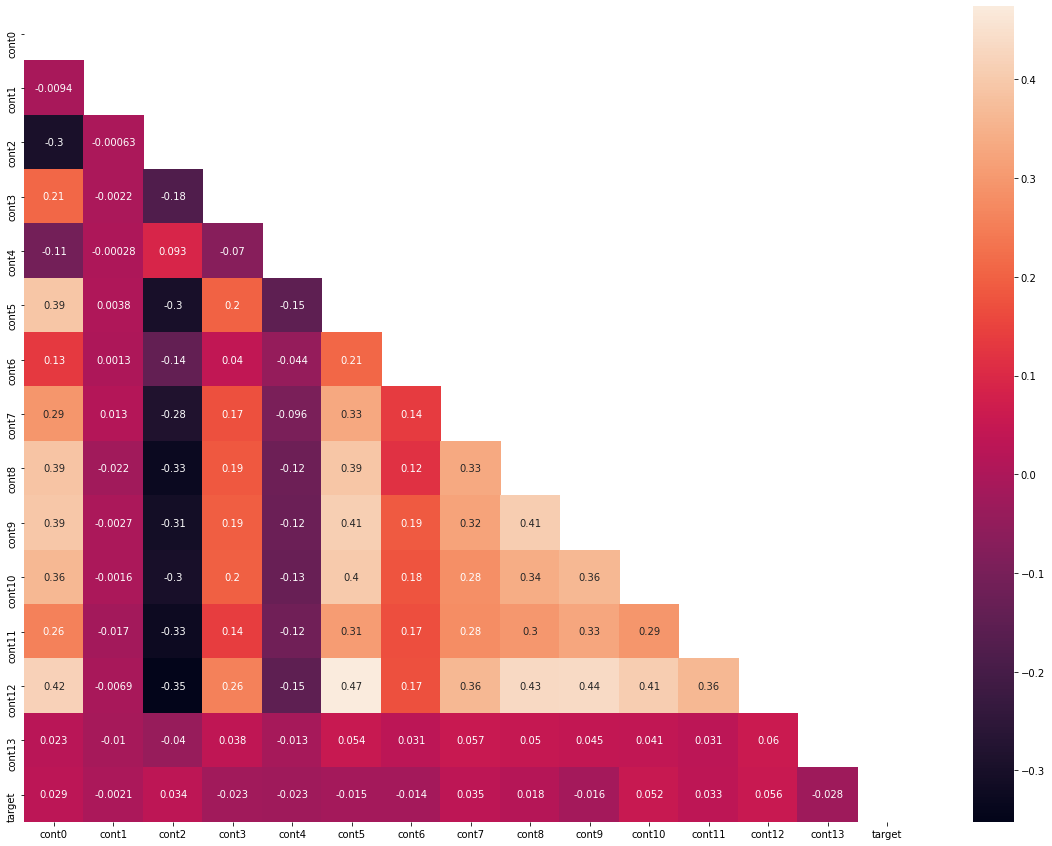

In [ ]:
plt.figure(figsize=(20,15))
mask = np.triu(np.ones(df.corr().shape))
sns.heatmap(df.corr(), annot=True, mask=mask)

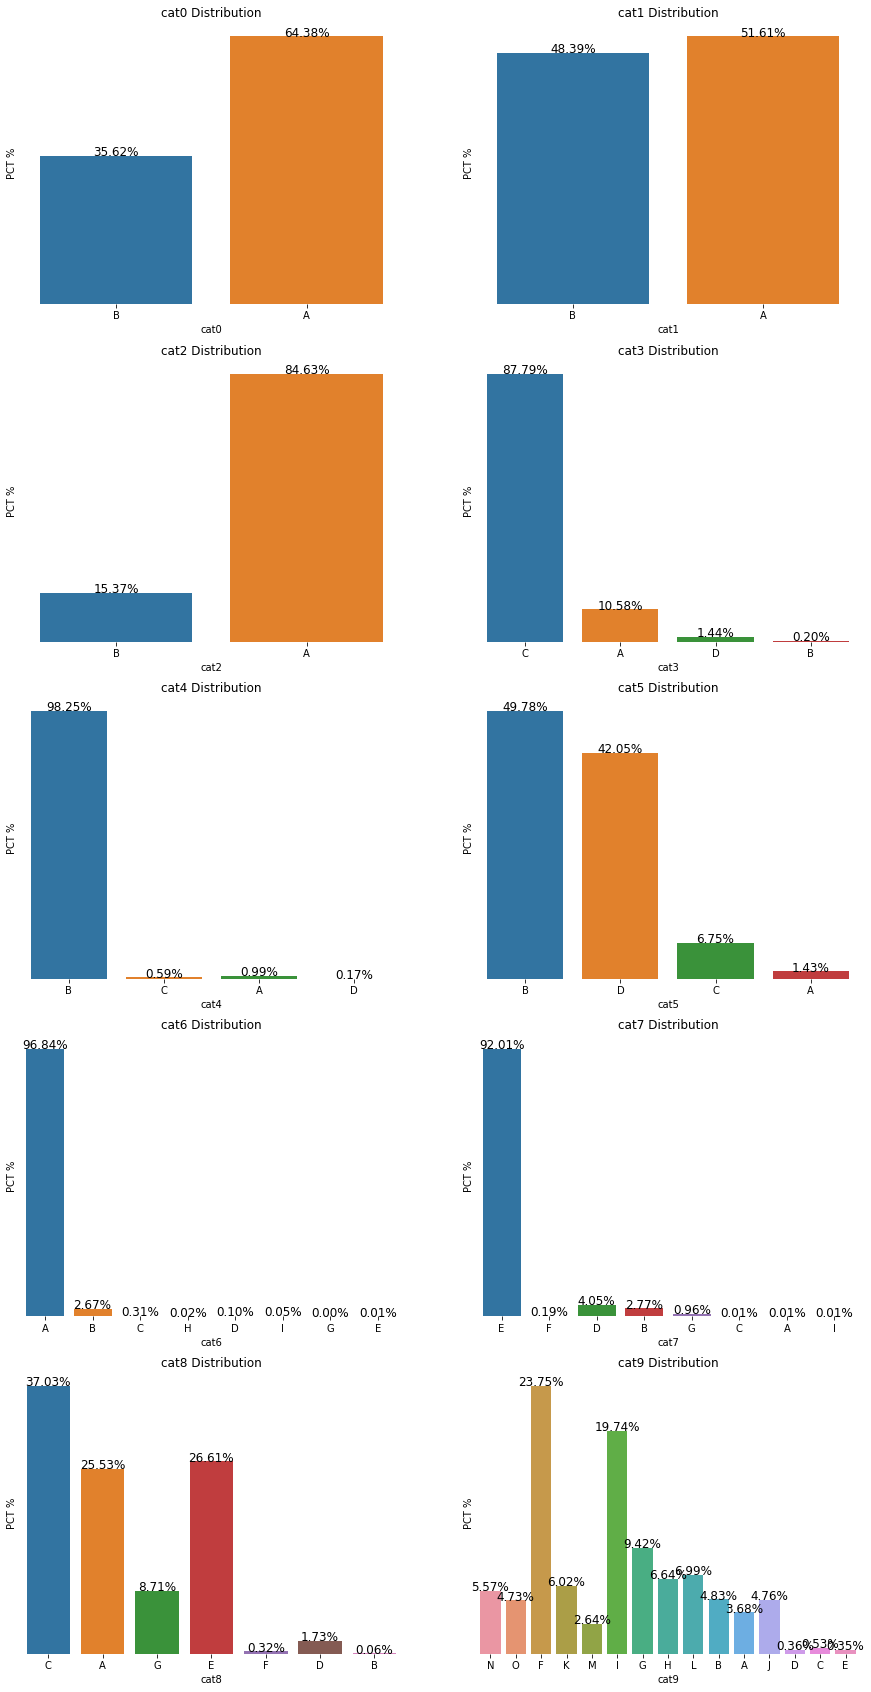

In [ ]:
def count_plots_cat(df, num_rows=ceil(len(cat_cnames)/2),num_cols =2 , col_names=cat_cnames):

    fix, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15,30))
    axes = axes.ravel()
    for i in range(len(col_names)):
        col = col_names[i]
        sns.countplot(df[col], ax=axes[i]);
        axes[i].set_title(f"{col} Distribution");
        axes[i].set_yticklabels([]) # removing labels
        axes[i].set_yticks([]) # removign ticks
        axes[i].set_ylabel("PCT %")
        # removing borders 
        axes[i].spines['top'].set_visible(False)
        axes[i].spines['right'].set_visible(False)
        axes[i].spines['bottom'].set_visible(False)
        axes[i].spines['left'].set_visible(False)
        # showing values in plot
        for patch in axes[i].patches:
            # get the height of the patch
            h = patch.get_height()
            axes[i].text(patch.get_x()+patch.get_width()/2,
                        h+8,'{:.2f}%'.format(h*100/len(df)),
                    fontsize = 12,ha = 'center')


count_plots_cat(df)

In [ ]:
# category columns with 1 value of more than 90% of data 
one_value_cat = []
for cname in cat_cnames:
    if df[cname].value_counts().iloc[0]/len(df) > 0.9:
        one_value_cat.append(cname)

one_value_cat

['cat4', 'cat6', 'cat7']

In [ ]:
df['cat0'].value_counts().iloc[0]/len(df) > 0.9

False

In [ ]:
df.corr()[df.corr()>=0.3][df.corr()!=1]

,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
cont0,NaN,NaN,NaN,NaN,NaN,0.392456,NaN,NaN,0.388510,0.394969,0.363413,NaN,0.417872,NaN,NaN
cont1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cont2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cont3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cont4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cont5,0.392456,NaN,NaN,NaN,NaN,NaN,NaN,0.329357,0.392057,0.411366,0.402053,0.308249,0.473964,NaN,NaN
cont6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cont7,NaN,NaN,NaN,NaN,NaN,0.329357,NaN,NaN,0.332639,0.320239,NaN,NaN,0.363091,NaN,NaN
cont8,0.388510,NaN,NaN,NaN,NaN,0.392057,NaN,0.332639,NaN,0.406517,0.341430,NaN,0.434196,NaN,NaN
cont9,0.394969,NaN,NaN,NaN,NaN,0.411366,NaN,0.320239,0.406517,NaN,0.361941,0.327866,0.437776,NaN,NaN


In [ ]:
df.describe()

,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
count,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,0.527335,0.460926,0.490498,0.496689,0.491654,0.510526,0.467476,0.537119,0.498456,0.474872,0.474492,0.473216,0.494561,0.508273,8.241979
std,0.230599,0.214003,0.253346,0.219199,0.240074,0.228232,0.210331,0.218140,0.239920,0.218007,0.255949,0.222022,0.247292,0.222950,0.746555
min,-0.118039,-0.069309,-0.056104,0.130676,0.255908,0.045915,-0.224689,0.203763,-0.260275,0.117896,0.048732,0.052608,-0.074208,0.151050,0.140329
25%,0.405965,0.310494,0.300604,0.329783,0.284188,0.354141,0.342873,0.355825,0.332486,0.306874,0.276017,0.308151,0.289074,0.300669,7.742071
50%,0.497053,0.427903,0.502462,0.465026,0.390470,0.488865,0.429383,0.504661,0.439151,0.434620,0.459975,0.433812,0.422887,0.472400,8.191373
75%,0.668060,0.615113,0.647512,0.664451,0.696599,0.669625,0.573383,0.703441,0.606056,0.614333,0.691579,0.642057,0.714502,0.758447,8.728634
max,1.058443,0.887253,1.034704,1.039560,1.055424,1.067649,1.111552,1.032837,1.040229,0.982922,1.055960,1.071444,0.975035,0.905992,10.411992


In [ ]:
# dropping cont12
dropped_cols = one_value_cat
df.drop(dropped_cols, axis=1, inplace=True)

In [ ]:
y = df.target.copy()
X = df.drop('target', axis=1).copy()

In [ ]:
# removing the dropped col names
cat_cnames = list(set(cat_cnames).difference(dropped_cols))

In [ ]:
# categorical columns transformation
ordinal_encode = OrdinalEncoder()
X[cat_cnames] = ordinal_encode.fit_transform(X[cat_cnames])
# scaling numerical columns
# scaler= StandardScaler()
# X[num_cnames] = scaler.fit_transform(X[num_cnames])
# X

In [ ]:
# # hot encoding categorical columns
# def oneHotEncode(df=X, colNames=cat_cnames):
#     for cname in cat_cnames:
#         dummies = pd.get_dummies(df[cname], prefix=cname)
#         df = pd.concat([df, dummies], axis=1)
#         # drop the encoded col
#         df.drop([cname], axis=1, inplace=True)
#     return df

# # applying encoding
# X = oneHotEncode()


In [ ]:
print(f"Shape of data after encoding: {X.shape}")

Shape of data after encoding: (300000, 21)


In [ ]:
X

,cat0,cat1,cat2,cat3,cat5,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
id,,,,,,,,,,,,,,,,,,,,,
1,1.0,1.0,1.0,2.0,1.0,2.0,13.0,0.201470,-0.014822,0.669699,0.136278,0.610706,0.400361,0.160266,0.310921,0.389470,0.267559,0.237281,0.377873,0.322401,0.869850
2,1.0,1.0,0.0,0.0,3.0,0.0,14.0,0.743068,0.367411,1.021605,0.365798,0.276853,0.533087,0.558922,0.516294,0.594928,0.341439,0.906013,0.921701,0.261975,0.465083
3,0.0,0.0,0.0,2.0,3.0,0.0,5.0,0.742708,0.310383,-0.012673,0.576957,0.285074,0.650609,0.375348,0.902567,0.555205,0.843531,0.748809,0.620126,0.541474,0.763846
4,1.0,1.0,0.0,2.0,3.0,2.0,10.0,0.429551,0.620998,0.577942,0.280610,0.284667,0.668980,0.239061,0.732948,0.679618,0.574844,0.346010,0.714610,0.540150,0.280682
6,0.0,0.0,0.0,2.0,3.0,0.0,13.0,1.058291,0.367492,-0.052389,0.232407,0.287595,0.686964,0.420667,0.648182,0.684501,0.956692,1.000773,0.776742,0.625849,0.250823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499993,1.0,1.0,0.0,0.0,3.0,0.0,8.0,0.697124,0.483452,0.297770,0.195821,0.307883,0.769792,0.450538,0.934360,1.005077,0.853726,0.422541,1.063463,0.697685,0.506404
499996,0.0,1.0,0.0,2.0,1.0,4.0,5.0,0.446200,0.715135,0.610931,0.601730,0.736713,0.528056,0.508502,0.358247,0.257825,0.433525,0.301015,0.268447,0.577055,0.823611
499997,1.0,1.0,0.0,2.0,2.0,6.0,5.0,0.544279,0.060937,0.590955,0.905308,0.277074,0.688747,0.372425,0.364936,0.383224,0.551825,0.661007,0.629606,0.714139,0.245732


In [ ]:
# splitting 
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
## Modeling
model = Sequential()
model.add(Dense(1024, activation='relu', input_dim=X.shape[1]))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))





# output layer
model.add(Dense(1, activation='relu'))
# Compile the network :
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              22528     
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               2

In [ ]:
# adding callback
checkpoint_name = os.path.join(OUTPUT_PATH,"weights",'Weights-{epoch:03d}--{val_loss:.5f}.hdf5') 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [ ]:
#batch_size = int(X_train.shape[0] / 50)
model.fit(X, y, epochs=25,batch_size=64, validation_split=0.2,callbacks=callbacks_list)

Epoch 1/25
3750/3750 [==============================] - 116s 31ms/step - loss: 0.7145 - mean_absolute_error: 0.7145 - val_loss: 0.6104 - val_mean_absolute_error: 0.6104

Epoch 00001: val_loss improved from inf to 0.61044, saving model to /content/drive/MyDrive/30-days-of-ml-competition1/output/weights/Weights-001--0.61044.hdf5
Epoch 2/25
3750/3750 [==============================] - 115s 31ms/step - loss: 0.6023 - mean_absolute_error: 0.6023 - val_loss: 0.5936 - val_mean_absolute_error: 0.5936

Epoch 00002: val_loss improved from 0.61044 to 0.59360, saving model to /content/drive/MyDrive/30-days-of-ml-competition1/output/weights/Weights-002--0.59360.hdf5
Epoch 3/25
3750/3750 [==============================] - 114s 30ms/step - loss: 0.5917 - mean_absolute_error: 0.5917 - val_loss: 0.5871 - val_mean_absolute_error: 0.5871

Epoch 00003: val_loss improved from 0.59360 to 0.58710, saving model to /content/drive/MyDrive/30-days-of-ml-competition1/output/weights/Weights-003--0.58710.hdf5
Epoch

In [ ]:
# Load wights file of the best model :
weights_file = f"/content/drive/MyDrive/30-days-of-ml-competition1/output/weights/Weights-014--0.58518.hdf5" # choose the best checkpoint 
model.load_weights(weights_file) # load it
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])


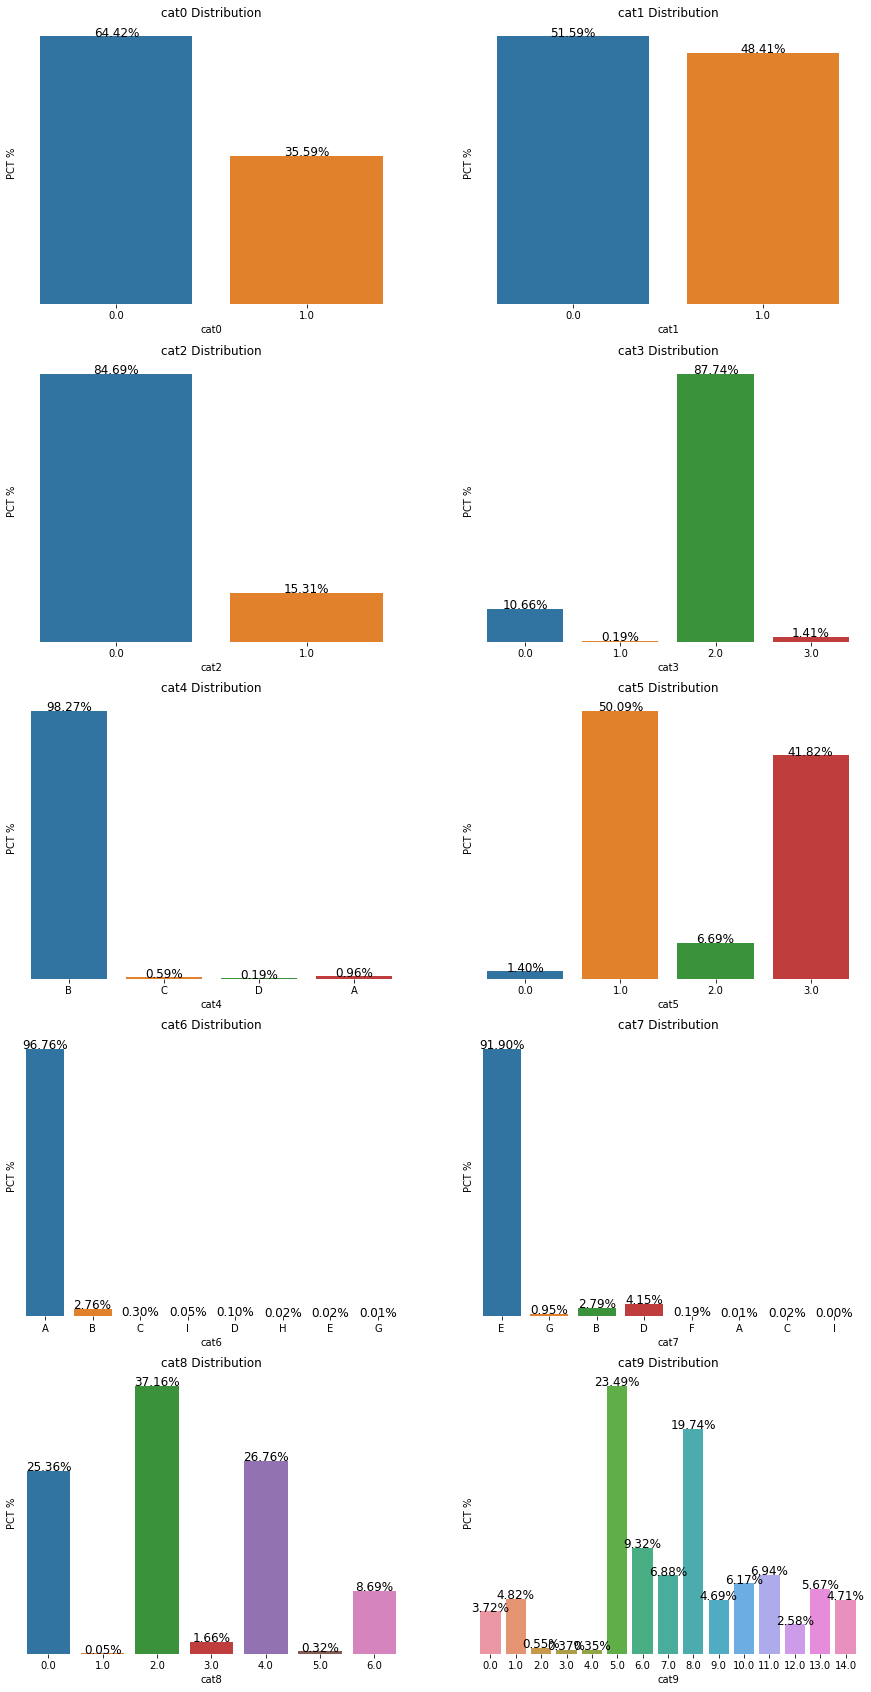

In [ ]:
X_test = pd.read_csv(TEST_DATA_PATH, index_col='id')
X_test[cat_cnames] = ordinal_encode.transform(X_test[cat_cnames])
count_plots_cat(X_test)
X_test.drop(dropped_cols, axis=1, inplace=True)

In [ ]:
# predictions 
predictions = model.predict(X_test)

In [ ]:
def output_submission(prediction, file_name):
    """creating a kaggle submission file

    Args:
        prediction (array): an array of predictions of the test dataset
        file_name (string): a string for the name without the extension
    """
    my_submission = pd.DataFrame({'target': predictions[:,0]},
                                 index=X_test.index)
    #my_submission.set_index('id')
    file_path = os.path.join(OUTPUT_PATH,file_name)
    my_submission.to_csv(f'{file_path}.csv')
    print(f'A submission file has been made at {file_path}')

In [ ]:
output_submission(predictions, "DL_submission3")

A submission file has been made at /content/drive/MyDrive/30-days-of-ml-competition1/output/DL_submission3
